In [1]:
import torch
print(torch.__version__)

2.6.0+cu126


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("data/Kannada_MNIST/train.csv")
# test_df = pd.read_csv("data/Kannada_MNIST/Dig-MNIST.csv")
# test_df = pd.read_csv("data/Kannada_MNIST/test.csv")

In [4]:
# y_train = torch.tensor(train_df.iloc[:,0])
# x_train = torch.tensor(np.array([i.reshape(28,28) for i in np.array(train_df.iloc[:,1:])]), dtype=torch.float32)

In [5]:
from sklearn.model_selection import train_test_split

x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(df.iloc[:,1:], df.iloc[:,0], test_size=0.1)

x_train = torch.tensor(np.array([i.reshape(28,28) for i in np.array(x_train_df)]), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train_df))

x_test = torch.tensor(np.array([i.reshape(28,28) for i in np.array(x_test_df)]), dtype=torch.float32)
y_test = torch.tensor(np.array(y_test_df))

In [6]:
print(x_train.shape,y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([54000, 28, 28]) torch.Size([54000])
torch.Size([6000, 28, 28]) torch.Size([6000])


Text(0.5, 1.0, 'tensor(6)')

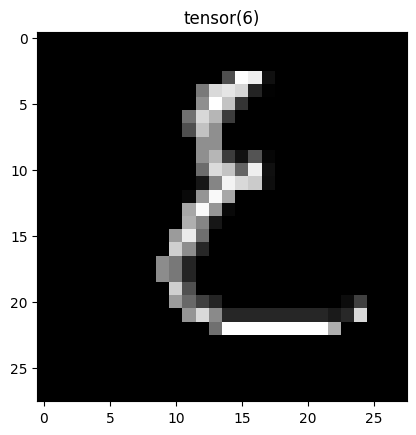

In [7]:
rand_int = np.random.randint(0,60000)
plt.imshow(x_train[rand_int],cmap='gray')
plt.title(y_train[rand_int])

In [8]:
# y_test = torch.tensor(test_df.iloc[:,0])
# x_test = torch.tensor([i.reshape(28,28) for i in np.array(test_df.iloc[:,1:])], dtype=torch.float32)

In [9]:
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

In [10]:
train_dataset = TensorDataset(x_train,y_train)
test_dataset = TensorDataset(x_test,y_test)

In [11]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False)

In [12]:
from torch import nn
class Model1(nn.Module):
    def __init__(self, in_shape: int, hidden_units: int, out_shape: int) -> nn.Module:
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=out_shape)
        )

    def forward(self,x):
        return self.layer1(x)

In [13]:
model1 = Model1(28*28,32,10)

In [14]:
def random_predictions():
    fig = plt.figure(figsize=(10,10))
    rows, cols = 3,3
    for i in range(1,rows*cols+1):
        rand_int = torch.randint(0,len(test_dataset),size=[1]).item()
        rand_img, rand_lbl = test_dataset[rand_int]
        y_pred = model1(rand_img.unsqueeze(0))
        pred_class = y_pred.argmax(dim=1)
        fig.add_subplot(rows,cols,i)
        plt.imshow(rand_img,cmap="gray")
        plt.title(f"Pred: {pred_class.item()}, Actual: {rand_lbl}")
        plt.axis(False)

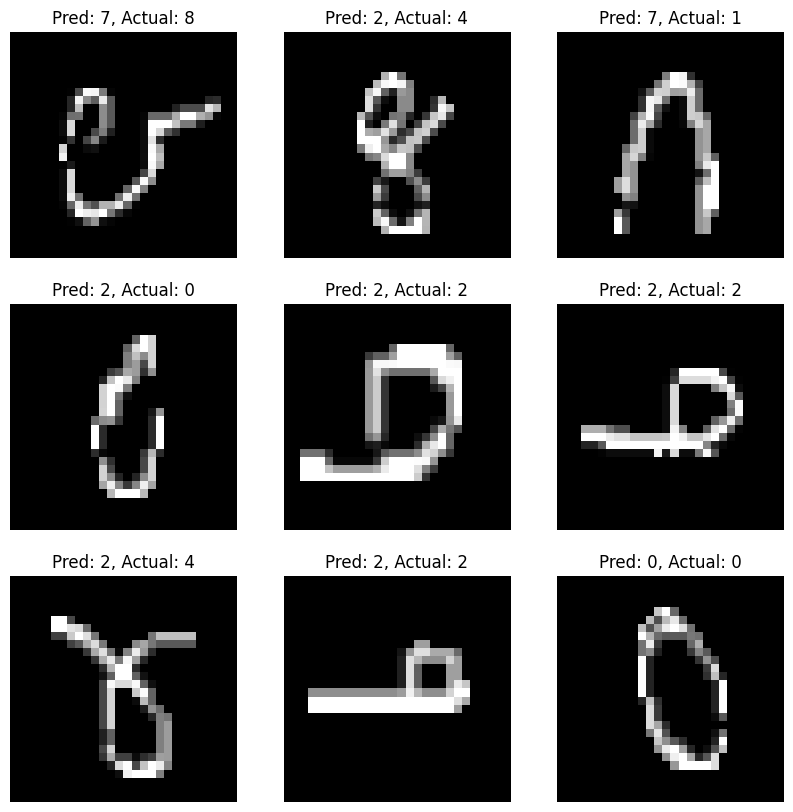

In [15]:
random_predictions()

In [16]:
def train_test_loop(model: nn.Module,
                    train_dataloader: torch.utils.data.DataLoader,
                    test_dataloader: torch.utils.data.DataLoader,
                   epochs: int,
                   loss_fn: nn.Module,
                   optimizer: torch.optim.Optimizer):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        for batch,(X,y) in enumerate(train_dataloader):
            y_pred = model(X)
            loss = loss_fn(y_pred,y)
            y_out = torch.argmax(y_pred, dim=1)
            train_acc += (torch.eq(y, y_out).sum().item())/len(y_out)
            train_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        model.eval()
        test_loss = 0
        test_acc = 0
        with torch.inference_mode():
            for batch,(X,y) in enumerate(test_dataloader):
                y_pred = model(X)
                loss = loss_fn(y_pred,y)
                y_out = torch.argmax(y_pred, dim=1)
                test_acc += (torch.eq(y, y_out).sum().item())/len(y_out)
                test_loss += loss
            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)
        print(f"Epoch: {epoch+1}\nTrain loss: {train_loss}, Train accuracy: {train_acc*100:.2f} | Test loss: {test_loss}, Test accuracy: {test_acc*100:.2f}")

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(),lr=0.001)

In [18]:
train_test_loop(
    model1,
    train_dataloader,
    test_dataloader,
    10,
    loss_fn,
    optimizer
)

Epoch: 1
Train loss: 0.4266882836818695, Train accuracy: 92.77 | Test loss: 0.26616933941841125, Test accuracy: 94.32
Epoch: 2
Train loss: 0.21464167535305023, Train accuracy: 94.55 | Test loss: 0.26282110810279846, Test accuracy: 93.85
Epoch: 3
Train loss: 0.19237716495990753, Train accuracy: 94.94 | Test loss: 0.17971225082874298, Test accuracy: 95.01
Epoch: 4
Train loss: 0.16977053880691528, Train accuracy: 95.22 | Test loss: 0.24599865078926086, Test accuracy: 93.42
Epoch: 5
Train loss: 0.1631273776292801, Train accuracy: 95.45 | Test loss: 0.21685084700584412, Test accuracy: 94.32
Epoch: 6
Train loss: 0.15549752116203308, Train accuracy: 95.54 | Test loss: 0.1893787831068039, Test accuracy: 94.83
Epoch: 7
Train loss: 0.1500742882490158, Train accuracy: 95.61 | Test loss: 0.19641496241092682, Test accuracy: 94.30
Epoch: 8
Train loss: 0.14388340711593628, Train accuracy: 95.83 | Test loss: 0.1957317292690277, Test accuracy: 94.96
Epoch: 9
Train loss: 0.13660450279712677, Train accur

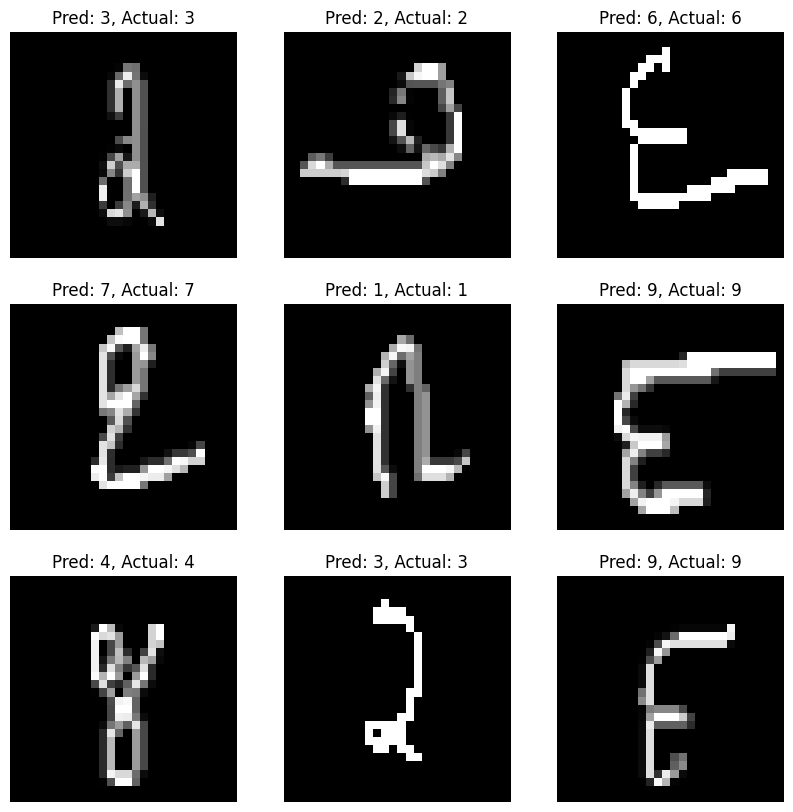

In [19]:
random_predictions()